In [94]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Dependencies

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import shutil

In [0]:
import fastai as f
import fastai.vision as fv

In [0]:
from pathlib import Path

# Creating own dataset from google imagee


Get a list of URLs
Search and scroll

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.
Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.


In [63]:
from google.colab import files
uploaded = files.upload()

Saving airplane.zip to airplane.zip


In [65]:
!unzip airplane

Archive:  airplane.zip
   creating: airplane/
  inflating: airplane/urls_rocket.txt  
  inflating: airplane/urls_passenger.txt  
  inflating: airplane/urls_fighterjet.txt  
  inflating: airplane/urls_helicopter.txt  
  inflating: airplane/urls_missile.txt  
  inflating: airplane/urls_drone.txt  


In [0]:
files = os.listdir('airplane/')

In [0]:
folders = [each[5:-4] for each in files]

In [78]:
files

['urls_drone.txt',
 'urls_missile.txt',
 'urls_fighter-jet.txt',
 'urls_rocket.txt',
 'urls_helicopter.txt',
 'urls_passenger-plane.txt']

In [80]:
folders

['drone', 'missile', 'fighter-jet', 'rocket', 'helicopter', 'passenger-plane']

In [0]:
url_dir = Path('airplane/')

In [0]:
for i in range(len(files)):
  # data path
  path = Path('data/planes')
  dest  = path/folders[i]
  dest.mkdir(parents=True, exist_ok=True)
  fv.download_images(url_dir/files[i], dest, max_pics=5000)

In [85]:
len(os.listdir('data/planes/drone/'))

1416

In [0]:
classes = folders

In [0]:
for c in classes:
  fv.verify_images(path/c, delete=True, max_workers=8)

In [88]:
for c in classes:
  print(len(os.listdir(path/c)))

1332
1334
1867
1186
1387
1424


In [0]:
# !zip -r planes.zip data

In [0]:
#move the dataset into drive
!cp planes.zip drive/My\ Drive/ 

In [89]:
path

PosixPath('data/planes')

In [0]:
data = fv.ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=fv.get_transforms(), size=224, num_workers=4)

In [0]:
data = data.normalize()

In [96]:
data.classes

['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']

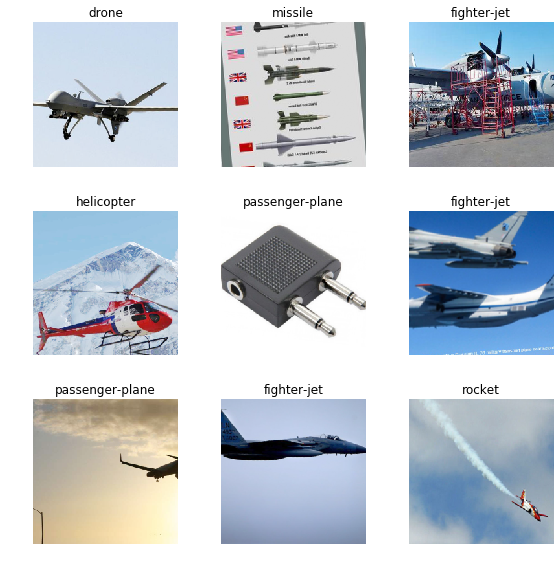

In [104]:
data.show_batch(rows=3, figsize=(8, 8))

In [106]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['drone',
  'fighter-jet',
  'helicopter',
  'missile',
  'passenger-plane',
  'rocket'],
 6,
 6752,
 1688)

# create and train model

In [107]:
model = fv.create_cnn(data, fv.models.resnet34, metrics=fv.accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 22.6MB/s]


In [108]:
model.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.807103,1.088729,0.642772,06:12
1,1.289771,0.948960,0.648104,06:11
2,1.040212,0.839376,0.706754,06:24
3,0.910589,0.802935,0.710900,06:14
4,0.851238,0.789888,0.716232,06:11


In [109]:
model.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.923470,0.824074,0.710308,06:22
1,0.857709,0.780914,0.719787,06:25


In [0]:
model.save('stage-1')

In [0]:
model.unfreeze()

In [112]:
model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


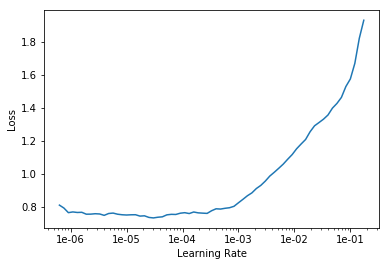

In [113]:
model.recorder.plot()

In [114]:
model.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.773738,0.760283,0.721564,06:30
1,0.729111,0.746852,0.725711,06:16


In [0]:
model.save('stage-2')

## interpretation

In [0]:
interp = fv.ClassificationInterpretation.from_learner(model)

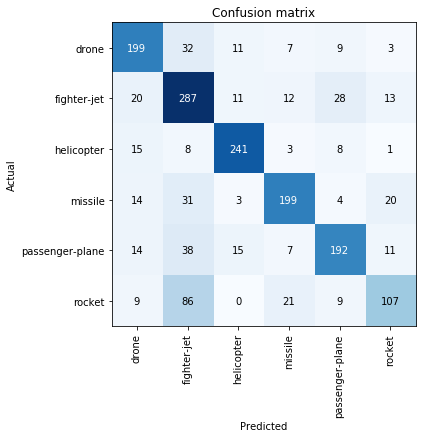

In [120]:
interp.plot_confusion_matrix(figsize=(6, 6))

In [0]:
from fastai.widgets import *

In [0]:
db = (fv.ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(fv.get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = fv.cnn_learner(db, fv.models.resnet34, metrics=fv.error_rate)

In [0]:
learn_cln.load('stage-2');

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [147]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)